In [2]:
!pip install xgboost
!pip install plotnine

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sys
import os
import glob
import numpy as np
import plotnine
from plotnine import *

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from sharepoint_transfer.src import main as sharepoint_transfer_svc
from data_consolidation.src import main as data_consolidation_svc
from feature_engineering.src import main as feature_engineering_svc
from model_selection.src import main as model_selection_svc
from outcome_analysis.src import main as outcome_analysis_svc
from model_training.src import main as model_training_svc
from final_fitting.src import main as final_fitting_svc
from ensemble_model.src import main as ensemble_model_svc

from model_dataset.src.main import load_dataframe
from artificial_anomaly_tests.aa_tests import artificial_anomaly_test_xgb
from model_training import xgbr_test

## Set Measure Specific Settings

These will augment and override settings in "/root/HAIP/notebooks/services/config.json"

In [91]:
SKIP_TUNING = False
SKIP_RMSE_TEST = False

settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "OP-22.csv",
    "FULL_MEASURE_S3_PREFIX": "OP-22",
    "filter_measure": "OP_22", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "shift_range": range(2, 10), # for isolation_forest
    
    # Feature Engineering options
    "backfill_prov_mean": False, # set to false to not backfill prov mean
    "backfill_lag": False, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

## Move Sharepoint files to S3

This is not possible in SageMaker Studio because we are trying to figure out Client ID/Secret for the Sharepoint REST API. For now, run the service locally using your own Office365 username/password

## Data Consolidation

Make sure the measure `settings` are changed.


Call `data_consolidation_main.main(settings)`


This will download the full-measure-data in S3, load it into a single data frame, normalize the columns, filter to only include `filter_measure` and then upload the result to S3.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-measure-specific-data?region=us-east-1&tab=objects

In [6]:
# data_consolidation_svc.main(settings)

## Feature Engineering

Call `feature_engineering_main.main(settings)`

This will download the consolidated measure-specific-data in S3, normalize the columns, and add the new features, then upload the result to S3.
Results should also be saved locally automatically, but that is not yet implemented. For now download from the link below and upload the file to SageMaker Studio.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-modeling-dataset?region=us-east-1&tab=objects

In [7]:
# feature_engineering_svc.main(settings)

## XGBoost Regression

### Feature Importance

In [8]:
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression", 
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2]], # [[0.05, 0.1, 0.2, 0.3]]
        'gamma': [range(0, 3)],
        'max_depth': [range(3, 11)], # [range(5, 10)]
        'min_child_weight': [range(3, 11)], # [range(3, 10)]
        'subsample': [[0.7, 1]], # [[1]] #.7 does 2/3 vars each time
        'alpha': [[0, 1, 2]],
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff', 'lag2'],
}

settings = {**settings, **xgbr_feature_importance_settings}

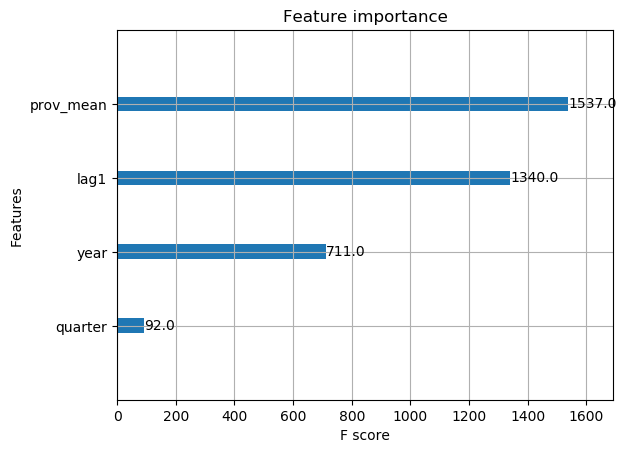

In [9]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [10]:
xgbr_drop_cols = ['provider_id', 'lag2', 'lag_diff', 'prov_mean_diff', 'quarter']
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression",
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_feature_importance_settings}

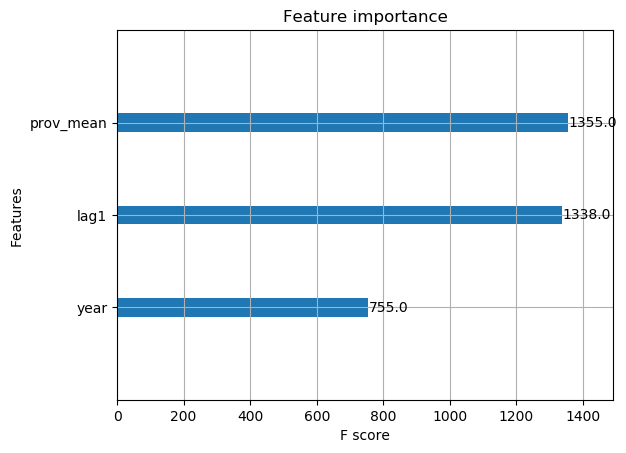

In [11]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [12]:
xgbr_tuner.modeling_df

,score,lag1,year,prov_mean
1,12.0,8.0,2013,8.000000
2,8.0,12.0,2014,10.000000
3,8.0,8.0,2014,9.333333
4,6.0,8.0,2015,9.000000
5,5.0,6.0,2016,8.400000
...,...,...,...,...
26859,4.0,3.0,2015,2.500000
26860,6.0,4.0,2016,2.800000
26861,3.0,6.0,2017,3.333333
26862,4.0,3.0,2018,3.285714


### Tuning

In [13]:
candidate = None
if not SKIP_TUNING:
    candidate = xgbr_tuner.tune()

In [14]:
candidate

### Model Selection

Make sure `model_run_data_path` is set in settings to the tuning result path.
Make sure `model_type` is set in settings to `XGBRegression`, `Isolation Forest`, or `Ensemble`

Call `model_selector = model_selection_main.get_model_selector(settings)` to get the appropriate selector.
Then call `model_selector.get_top_models()` to get the top models

To get the candidate model that matches one of the top_model:
     Call `model_selector.get_candidate_model_by_index(INDEX)` to get the candidate model
     Call `model_selector.get_candidate_model_params_by_index(INDEX)` to get the candidate model params

For `model_run_data_path` right click the file in side nav and choose `Copy Path`. Paste that and add a `/root/` before it.

In [15]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgboost_regression/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgboost_regression/tuning_results_run_2022-12-02-14h43m.csv


In [16]:
xgbr_model_selector = model_selection_svc.get_model_selector(settings)
xgbr_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
1892,-1.5081,0.2438,1,1,0.10,2,9,5,0.7,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."
3044,-1.5085,0.2400,2,2,0.10,2,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
2932,-1.5088,0.2433,3,2,0.10,1,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
2788,-1.5089,0.2414,4,2,0.10,0,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
2804,-1.5093,0.2420,5,2,0.10,0,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
2916,-1.5095,0.2410,6,2,0.10,1,9,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
2377,-1.5101,0.2473,7,2,0.05,0,7,7,1.0,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
3060,-1.5106,0.2412,8,2,0.10,2,10,5,0.7,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
2649,-1.5110,0.2466,9,2,0.05,2,8,7,1.0,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
1908,-1.5112,0.2426,10,1,0.10,2,10,5,0.7,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."


In [17]:
xgbr_model_index = 2649
# xgbr_model_index = xgbr_model_selector.get_top_models().iloc[0].name # default top model
xgbr_model_selector.get_candidate_model_by_index(xgbr_model_index)

mean_fit_time         1.7049
std_fit_time          0.5212
mean_score_time        0.021
std_score_time        0.0043
param_alpha                2
                       ...  
split48_test_score   -1.5442
split49_test_score   -1.7672
mean_test_score       -1.511
std_test_score        0.2466
rank_test_score            9
Name: 2649, Length: 64, dtype: object

In [18]:
xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index)

{'alpha': 2,
 'eta': 0.05,
 'gamma': 2,
 'max_depth': 8,
 'min_child_weight': 7,
 'subsample': 1}

### Final Fit

In [19]:
xgbr_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index),
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_final_fit_settings}

In [20]:
xgbr_fitter = final_fitting_svc.get_final_fitter(settings)
xgbr_model = xgbr_fitter.fit()

In [21]:
xgbr_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [22]:
threshold_range = range(1,100)

xgbr_aat_res = artificial_anomaly_test_xgb(
    model = xgbr_model, 
    model_data = xgbr_fitter.modeling_df,
    selected_features = ['lag1', 'year', 'prov_mean'],
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:5]

xgbr_threshold = xgbr_aat_res.iloc[0]['Threshold']
print("Using Threshold", xgbr_threshold)

xgbr_aat_res

Using Threshold 2.0


,Threshold,AUROC
1,2,0.915438
0,1,0.894687
2,3,0.875188
3,4,0.820687
4,5,0.767000


### CV RMSE

In [23]:
xgbr_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, xgbr_cv_rmse = xgbr_test.test_xgbr(xgbr_fitter.modeling_df)
xgbr_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished


1.811659451697596

## Isolation Forest

### Tuning

In [93]:
if_drop_cols = ['provider_id', 'lag2', 'year', 'quarter']
if_training_settings = {
    "model_type": "Isolation Forest", 
    "if_parameters": {
        # Features to include
        'features_included': [['lag_diff', 'prov_mean_diff']],
        # The number of base estimators in the ensemble.
        'n_estimators': [50, 75, 100, 150, 200, 300],
        # The number of samples to draw from X to train each base estimator.
        'max_samples': [512, 'auto', 200, 175, 128, 64],
        # The number of features to draw from X to train each base estimator.
        'max_features': [0.5, 1],
        # If True, individual trees are fit on random subsets of the training data sampled with replacement.
        # If False, sampling without replacement is performed.
        'bootstrap': [False, True]
    },
    "drop_cols": if_drop_cols, # use just lag1, prov_mean
}

settings = {**settings, **if_training_settings}

In [94]:
if_trainer = model_training_svc.get_model_trainer(settings)

In [95]:
if_trainer.modeling_df = if_trainer.modeling_df.dropna()
if_trainer.modeling_df

,score,lag1,lag_diff,prov_mean,prov_mean_diff
1,12.0,8.0,4.0,8.000000,4.000000
2,8.0,12.0,-4.0,10.000000,-2.000000
3,8.0,8.0,0.0,9.333333,-1.333333
4,6.0,8.0,-2.0,9.000000,-3.000000
5,5.0,6.0,-1.0,8.400000,-3.400000
...,...,...,...,...,...
26859,4.0,3.0,1.0,2.500000,1.500000
26860,6.0,4.0,2.0,2.800000,3.200000
26861,3.0,6.0,-3.0,3.333333,-0.333333
26862,4.0,3.0,1.0,3.285714,0.714286


In [98]:
candidate = None
if not SKIP_TUNING:
    candidate = if_trainer.tune()

KeyboardInterrupt: 

In [28]:
candidate

### Model Selection

In [99]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/isolation_forest/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

if_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

Using result:  model_runs/isolation_forest/tuning_results_run_2022-12-05-16h24m.csv


In [100]:
if_model_selector = model_selection_svc.get_model_selector(settings)
if_model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
105,True,"[lag_diff, prov_mean_diff]",0.5,64,150,106,0.9727,0.8883,0.8922,0.8975,0.9020,0.9053,0.9115,0.9161,0.9173,0.9181,0.9205,0.9216,0.9216,0.9235,0.9239,0.9056,0.9047
63,False,"[lag_diff, prov_mean_diff]",1.0,128,150,64,0.9725,0.8982,0.9037,0.9090,0.9152,0.9166,0.9196,0.9208,0.9228,0.9248,0.9244,0.9251,0.9236,0.9060,0.9064,0.9031,0.9011
99,True,"[lag_diff, prov_mean_diff]",0.5,128,150,100,0.9723,0.8983,0.9033,0.9078,0.9141,0.9160,0.9188,0.9203,0.9220,0.9236,0.9236,0.9244,0.9225,0.9060,0.9063,0.9029,0.9007
101,True,"[lag_diff, prov_mean_diff]",0.5,128,300,102,0.9719,0.8966,0.9047,0.9077,0.9139,0.9153,0.9184,0.9193,0.9208,0.9236,0.9232,0.9237,0.9058,0.9060,0.9044,0.9011,0.8986
33,False,"[lag_diff, prov_mean_diff]",0.5,64,150,34,0.9718,0.8869,0.8901,0.8951,0.8994,0.9037,0.9093,0.9142,0.9159,0.9163,0.9186,0.9200,0.9195,0.9211,0.9217,0.9049,0.9042
69,False,"[lag_diff, prov_mean_diff]",1.0,64,150,70,0.9718,0.8877,0.8907,0.8958,0.9002,0.9042,0.9097,0.9145,0.9161,0.9167,0.9187,0.9203,0.9198,0.9215,0.9221,0.9046,0.9036
87,True,"[lag_diff, prov_mean_diff]",0.5,200,150,88,0.9718,0.9073,0.9134,0.9156,0.9188,0.9202,0.9245,0.9247,0.9239,0.9226,0.9068,0.9061,0.9045,0.9017,0.9007,0.8980,0.8969
57,False,"[lag_diff, prov_mean_diff]",1.0,175,150,58,0.9717,0.9034,0.9105,0.9128,0.9146,0.9166,0.9210,0.9238,0.9243,0.9234,0.9060,0.9066,0.9059,0.9042,0.9022,0.9001,0.8975
26,False,"[lag_diff, prov_mean_diff]",0.5,128,100,27,0.9716,0.8991,0.9026,0.9084,0.9144,0.9168,0.9193,0.9216,0.9215,0.9215,0.9240,0.9233,0.9062,0.9053,0.9023,0.9005,0.8990
123,True,"[lag_diff, prov_mean_diff]",1.0,200,150,124,0.9716,0.9064,0.9129,0.9149,0.9178,0.9192,0.9231,0.9239,0.9236,0.9225,0.9071,0.9065,0.9048,0.9022,0.9010,0.8990,0.8979


In [102]:
if_model_id = 64
# if_model_id = if_model_selector.get_top_models().iloc[0].model_id # default top model
if_model_selector.get_candidate_model_by_index(if_model_id)

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
63,False,"[lag_diff, prov_mean_diff]",1.0,128,150,64,0.9725,0.8982,0.9037,0.909,0.9152,0.9166,0.9196,0.9208,0.9228,0.9248,0.9244,0.9251,0.9236,0.906,0.9064,0.9031,0.9011


In [103]:
if_model_selector.get_candidate_model_params_by_index(if_model_id)

{'bootstrap': False,
 'features_included': ['lag_diff', 'prov_mean_diff'],
 'max_features': 1,
 'max_samples': 128,
 'n_estimators': 150}

### Final Fit

In [104]:
if_final_fit_settings = {
    "model_type": "Isolation Forest",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "if_final_params": if_model_selector.get_candidate_model_params_by_index(if_model_id),
    "drop_cols": if_drop_cols,
}

del if_final_fit_settings['if_final_params']['features_included']

settings = {**settings, **if_final_fit_settings}

In [105]:
if_fitter = final_fitting_svc.get_final_fitter(settings)
if_model = if_fitter.fit()

In [106]:
if_model

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples=128, n_estimators=150, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7FBF207DF8D0, verbose=0,
                warm_start=False)

In [107]:
if_anomaly_scores = if_fitter.get_anomaly_scores()
if_anomaly_scores

array([0.75678093, 0.72011767, 0.61040453, ..., 0.55685446, 0.51191503,
       0.55119071])

### Threshold

In [151]:
_candidate = if_model_selector.get_candidate_model_by_index(if_model_id)
_candidate = _candidate.drop(columns=[col for col in _candidate.columns if 'auroc_threshold_' not in col])

highest_auroc = _candidate.max().max()
threshold_col_name = None
for col in _candidate.columns:
    if _candidate[col].item() == highest_auroc:
        threshold_col_name = col
        break

if threshold_col_name is None:
    print("Could not find threshold for Isolation Forest")
else:
    if_threshold = float(threshold_col_name.replace('auroc_threshold_', ''))
    print("Using threshold", if_threshold, "based on highest value", highest_auroc)

Using threshold 0.6 based on highest value 0.9251


In [130]:
# if_threshold = 0.62

## Ensemble Model

### Feature Importance

In [39]:
ensemble_settings = {
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2]], # [[0.05, 0.1, 0.2, 0.3]]
        'gamma': [range(0, 3)],
        'max_depth': [range(3, 11)], # [range(5, 10)]
        'min_child_weight': [range(3, 11)], # [range(3, 10)]
        'subsample': [[0.7, 1]], # [[1]] #.7 does 2/3 vars each time
        'alpha': [[0, 1, 2]],
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff', 'lag2'],
    "if_model": if_model,
    "if_anomaly_scores": if_anomaly_scores,
}

settings = {**settings, **ensemble_settings}

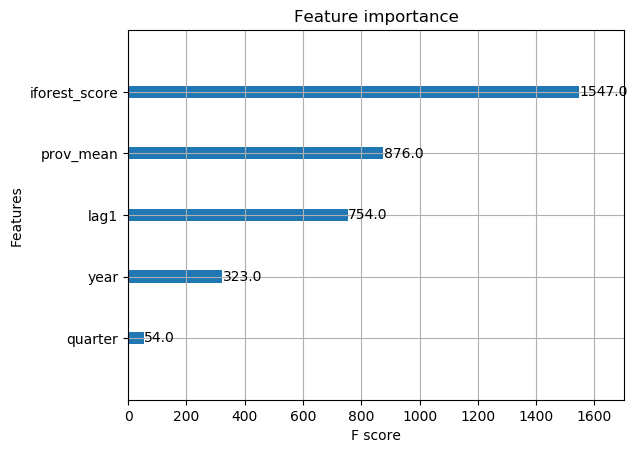

In [40]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [41]:
ensemble_drop_cols = ['provider_id', 'lag2', 'prov_mean_diff', 'year', 'quarter', 'lag_diff']
ensemble_settings = {
    "drop_cols": ensemble_drop_cols
}

settings = {**settings, **ensemble_settings}

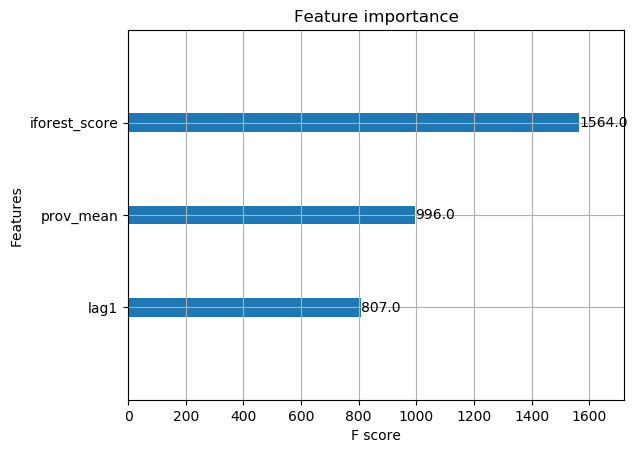

In [42]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

### Tuning

In [43]:
candidate = None
if not SKIP_TUNING:
    candidate = ensemble_trainer.tune()

In [44]:
candidate

In [45]:
ensemble_trainer.modeling_df

,score,lag1,prov_mean,iforest_score
1,12.0,8.0,8.000000,0.759779
2,8.0,12.0,10.000000,0.722145
3,8.0,8.0,9.333333,0.612750
4,6.0,8.0,9.000000,0.683928
5,5.0,6.0,8.400000,0.639331
...,...,...,...,...
26859,4.0,3.0,2.500000,0.522494
26860,6.0,4.0,2.800000,0.611817
26861,3.0,6.0,3.333333,0.565036
26862,4.0,3.0,3.285714,0.516643


### Model Selection

In [46]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgbr_ensemble/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgbr_ensemble/tuning_results_run_2022-12-01-21h25m.csv


In [47]:
ensemble_model_selector = model_selection_svc.get_model_selector(settings)
ensemble_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
452,-1.0578,0.3243,1,1,0.05,0,9,7,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
557,-1.0593,0.3265,2,1,0.10,0,9,7,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 0, 'max_dept..."
172,-1.0605,0.3232,3,0,0.10,1,9,7,1,"{'alpha': 0, 'eta': 0.1, 'gamma': 1, 'max_dept..."
451,-1.0607,0.3291,4,1,0.05,0,9,6,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
872,-1.0609,0.3240,6,2,0.05,0,9,7,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
592,-1.0609,0.3258,5,1,0.10,1,9,7,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 1, 'max_dept..."
67,-1.0613,0.3261,7,0,0.05,1,9,7,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 1, 'max_dep..."
32,-1.0615,0.3271,8,0,0.05,0,9,7,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep..."
906,-1.0616,0.3311,9,2,0.05,1,9,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
871,-1.0621,0.3302,10,2,0.05,0,9,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."


In [48]:
# ensemble_model_index = 906
ensemble_model_index = ensemble_model_selector.get_top_models().iloc[0].name # default top model
ensemble_model_selector.get_candidate_model_by_index(ensemble_model_index)

mean_fit_time         2.1996
std_fit_time          0.3104
mean_score_time       0.0255
std_score_time         0.004
param_alpha                1
                       ...  
split48_test_score   -1.0428
split49_test_score   -1.3356
mean_test_score      -1.0578
std_test_score        0.3243
rank_test_score            1
Name: 452, Length: 64, dtype: object

In [49]:
ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index)

{'alpha': 1,
 'eta': 0.05,
 'gamma': 0,
 'max_depth': 9,
 'min_child_weight': 7,
 'subsample': 1}

### Final Fit

In [50]:
ensemble_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index),
    "drop_cols": ensemble_drop_cols,
}

settings = {**settings, **ensemble_final_fit_settings}

In [51]:
ensemble_fitter = ensemble_model_svc.get_ensemble_final_fitter(settings)
ensemble_model = ensemble_fitter.fit()

In [52]:
ensemble_model

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=7,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [53]:
threshold_range = range(1,100)

ensemble_aat_res = artificial_anomaly_test_xgb(
    model = ensemble_model,
    model_data = ensemble_fitter.modeling_df,
    selected_features = ['lag1','prov_mean', 'iforest_score'],
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:5]

ensemble_threshold = ensemble_aat_res.iloc[0].name
print("Using Threshold", ensemble_threshold)

ensemble_aat_res

Using Threshold 0


,Threshold,AUROC
0,1,0.975625
1,2,0.942812
2,3,0.892000
3,4,0.831562
4,5,0.772063


### CV RMSE

In [54]:
ensemble_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, ensemble_cv_rmse = xgbr_test.test_xgbr(ensemble_fitter.modeling_df)
ensemble_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.6s finished


1.2800318749705655

## Outcome Analysis

In [152]:
outcome_analysis_settings = {
    "if_model": if_model,
    "if_threshold": if_threshold,

    "xgbr_model": xgbr_model,
    "xgbr_threshold": xgbr_threshold,
    
    "ensemble_model": ensemble_model,
    "ensemble_threshold": ensemble_threshold,
}

settings = {**settings, **outcome_analysis_settings}

In [153]:
modeling_dataset = load_dataframe(settings.get('model_dataset_path'), []).dropna(subset = ['lag1'])
modeling_dataset['y_quarter'] = modeling_dataset['year'].astype(str) + 'Q' + modeling_dataset['quarter'].astype(str)
modeling_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,12.0,8.0,NaN,2013,4,4.0,8.000000,4.000000,2013Q4
2,100001,8.0,12.0,8.0,2014,2,-4.0,10.000000,-2.000000,2014Q2
3,100001,8.0,8.0,12.0,2014,4,0.0,9.333333,-1.333333,2014Q4
4,100001,6.0,8.0,8.0,2015,4,-2.0,9.000000,-3.000000,2015Q4
5,100001,5.0,6.0,8.0,2016,4,-1.0,8.400000,-3.400000,2016Q4
...,...,...,...,...,...,...,...,...,...,...
26859,90011,4.0,3.0,2.0,2015,4,1.0,2.500000,1.500000,2015Q4
26860,90011,6.0,4.0,3.0,2016,4,2.0,2.800000,3.200000,2016Q4
26861,90011,3.0,6.0,4.0,2017,4,-3.0,3.333333,-0.333333,2017Q4
26862,90011,4.0,3.0,6.0,2018,4,1.0,3.285714,0.714286,2018Q4


In [154]:
xgbr_scores = xgbr_model.predict(modeling_dataset[['lag1','year', 'prov_mean']])
xgbr_prediction = abs(modeling_dataset['score'] - xgbr_scores) > settings.get('xgbr_threshold')

xgbr_dataset = modeling_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgbr_dataset['outlier'] = xgbr_prediction
xgbr_dataset['model_score'] = xgbr_scores
xgbr_dataset['model'] = "XGBoost Regression"
xgbr_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,12.0,2013Q4,100001,8.000000,4.0,4.000000,True,7.211014,XGBoost Regression
2,8.0,2014Q2,100001,10.000000,-4.0,-2.000000,False,8.086411,XGBoost Regression
3,8.0,2014Q4,100001,9.333333,0.0,-1.333333,False,9.180779,XGBoost Regression
4,6.0,2015Q4,100001,9.000000,-2.0,-3.000000,False,7.093551,XGBoost Regression
5,5.0,2016Q4,100001,8.400000,-1.0,-3.400000,False,5.862414,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
26859,4.0,2015Q4,90011,2.500000,1.0,1.500000,False,2.708744,XGBoost Regression
26860,6.0,2016Q4,90011,2.800000,2.0,3.200000,True,3.358475,XGBoost Regression
26861,3.0,2017Q4,90011,3.333333,-3.0,-0.333333,False,4.480388,XGBoost Regression
26862,4.0,2018Q4,90011,3.285714,1.0,0.714286,False,2.812337,XGBoost Regression


In [155]:
if_scores = if_model.score_samples(modeling_dataset.drop(columns=[*if_drop_cols, 'y_quarter'])) * -1
if_prediction = if_scores > settings.get('if_threshold')

if_dataset = modeling_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_dataset['outlier'] = if_prediction
if_dataset['model_score'] = if_scores
if_dataset['model'] = "Isolation Forest"
if_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,12.0,2013Q4,100001,8.000000,4.0,4.000000,True,0.756781,Isolation Forest
2,8.0,2014Q2,100001,10.000000,-4.0,-2.000000,True,0.720118,Isolation Forest
3,8.0,2014Q4,100001,9.333333,0.0,-1.333333,True,0.610405,Isolation Forest
4,6.0,2015Q4,100001,9.000000,-2.0,-3.000000,True,0.688510,Isolation Forest
5,5.0,2016Q4,100001,8.400000,-1.0,-3.400000,True,0.642708,Isolation Forest
...,...,...,...,...,...,...,...,...,...
26859,4.0,2015Q4,90011,2.500000,1.0,1.500000,False,0.522609,Isolation Forest
26860,6.0,2016Q4,90011,2.800000,2.0,3.200000,True,0.612429,Isolation Forest
26861,3.0,2017Q4,90011,3.333333,-3.0,-0.333333,False,0.556854,Isolation Forest
26862,4.0,2018Q4,90011,3.285714,1.0,0.714286,False,0.511915,Isolation Forest


In [156]:
ensemble_dataset = modeling_dataset.copy()[['lag1','prov_mean','score']]
ensemble_dataset['iforest_scores'] = if_scores
ensemble_scores = ensemble_model.predict(ensemble_dataset[['lag1','prov_mean','iforest_scores']])
ensemble_prediction = abs(ensemble_dataset['score'] - ensemble_scores) > settings.get('ensemble_threshold')

ensemble_dataset = modeling_dataset.copy()[['score', 'y_quarter', 'provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_dataset['outlier'] = ensemble_prediction
ensemble_dataset['model_score'] = ensemble_scores
ensemble_dataset['model'] = "Ensemble Model"
ensemble_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,12.0,2013Q4,100001,8.000000,4.0,4.000000,True,12.613640,Ensemble Model
2,8.0,2014Q2,100001,10.000000,-4.0,-2.000000,True,6.547438,Ensemble Model
3,8.0,2014Q4,100001,9.333333,0.0,-1.333333,True,8.214754,Ensemble Model
4,6.0,2015Q4,100001,9.000000,-2.0,-3.000000,True,5.953902,Ensemble Model
5,5.0,2016Q4,100001,8.400000,-1.0,-3.400000,True,5.270485,Ensemble Model
...,...,...,...,...,...,...,...,...,...
26859,4.0,2015Q4,90011,2.500000,1.0,1.500000,True,3.682225,Ensemble Model
26860,6.0,2016Q4,90011,2.800000,2.0,3.200000,True,5.955287,Ensemble Model
26861,3.0,2017Q4,90011,3.333333,-3.0,-0.333333,True,3.290211,Ensemble Model
26862,4.0,2018Q4,90011,3.285714,1.0,0.714286,True,2.948857,Ensemble Model


In [157]:
import pandas as pd

comparison_df = pd.concat([xgbr_dataset, if_dataset, ensemble_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,12.0,2013Q4,100001,8.000000,4.0,4.000000,True,7.211014,XGBoost Regression
2,8.0,2014Q2,100001,10.000000,-4.0,-2.000000,False,8.086411,XGBoost Regression
3,8.0,2014Q4,100001,9.333333,0.0,-1.333333,False,9.180779,XGBoost Regression
4,6.0,2015Q4,100001,9.000000,-2.0,-3.000000,False,7.093551,XGBoost Regression
5,5.0,2016Q4,100001,8.400000,-1.0,-3.400000,False,5.862414,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
26859,4.0,2015Q4,90011,2.500000,1.0,1.500000,True,3.682225,Ensemble Model
26860,6.0,2016Q4,90011,2.800000,2.0,3.200000,True,5.955287,Ensemble Model
26861,3.0,2017Q4,90011,3.333333,-3.0,-0.333333,True,3.290211,Ensemble Model
26862,4.0,2018Q4,90011,3.285714,1.0,0.714286,True,2.948857,Ensemble Model


### CV RMSE

#### XGBoost Regression

In [158]:
xgbr_cv_rmse

1.811659451697596

#### Ensemble Model

In [159]:
ensemble_cv_rmse

1.2800318749705655

In [160]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                True  \
Model             XGBoost Regression Isolation Forest XGBoost Regression   
Score count                  21859.0          21939.0             1117.0   
      mean                       2.0              1.9                5.6   
      std                        1.3              1.2                6.5   
      min                        1.0              1.0                1.0   
      10%                        1.0              1.0                1.0   
      25%                        1.0              1.0                2.0   
      50%                        2.0              2.0                5.0   
      75%                        2.0              2.0                7.0   
      90%                        4.0              4.0               10.0   
      max                       33.0             15.0              100.0   

Predicted Outlier                                  
Model             Isolation Forest Ensemble Model  
Score count                 1037.0        22976.0  
      mean                     6.7            2.1  
      std                      6.6            2.1  
      min                      1.0            1.0  
      10%                      2.0            1.0  
      25%                      4.0            1.0  
      50%                      6.0            2.0  
      75%                      8.0            3.0  
      90%                     10.0            4.0  
      max                    100.0          100.0

In [161]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2012Q4,1,6,16.67
2013Q4,151,2386,6.33
2014Q2,19,2757,0.69
2014Q4,170,2502,6.79
2015Q4,169,2640,6.40
2016Q4,163,2695,6.05
2017Q4,132,2677,4.93
2018Q4,115,2703,4.25
2019Q4,72,2015,3.57
2020Q4,125,2595,4.82


### Isolation Forest Outlier Counts by Quarter

In [162]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2012Q4,1,6,16.67
2013Q4,132,2386,5.53
2014Q2,114,2757,4.13
2014Q4,162,2502,6.47
2015Q4,130,2640,4.92
2016Q4,131,2695,4.86
2017Q4,120,2677,4.48
2018Q4,100,2703,3.70
2019Q4,66,2015,3.28
2020Q4,81,2595,3.12


### Ensemble Model Outlier Counts by Quarter

In [163]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,2757,2757,100.0
2018Q4,2703,2703,100.0
2016Q4,2695,2695,100.0
2017Q4,2677,2677,100.0
2015Q4,2640,2640,100.0
2020Q4,2595,2595,100.0
2014Q4,2502,2502,100.0
2013Q4,2386,2386,100.0
2019Q4,2015,2015,100.0
2012Q4,6,6,100.0


In [164]:
comparison_df = comparison_df.query("model != 'Ensemble Model'")

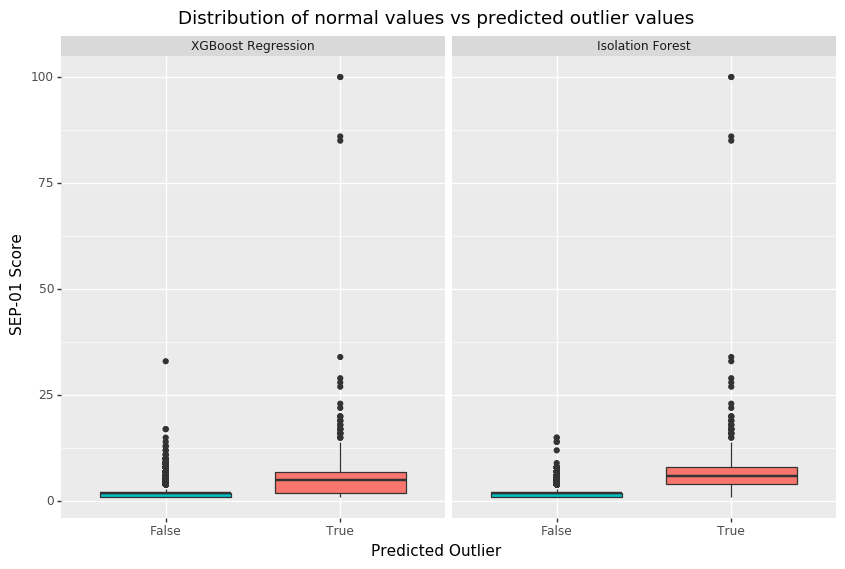

<ggplot: (8778624005101)>

In [165]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query("model != 'Ensemble Model'"),
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted outlier values")
 + ylab("SEP-01 Score")
 + xlab("Predicted Outlier")
 + labs(fill = 'Predicted Outlier')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


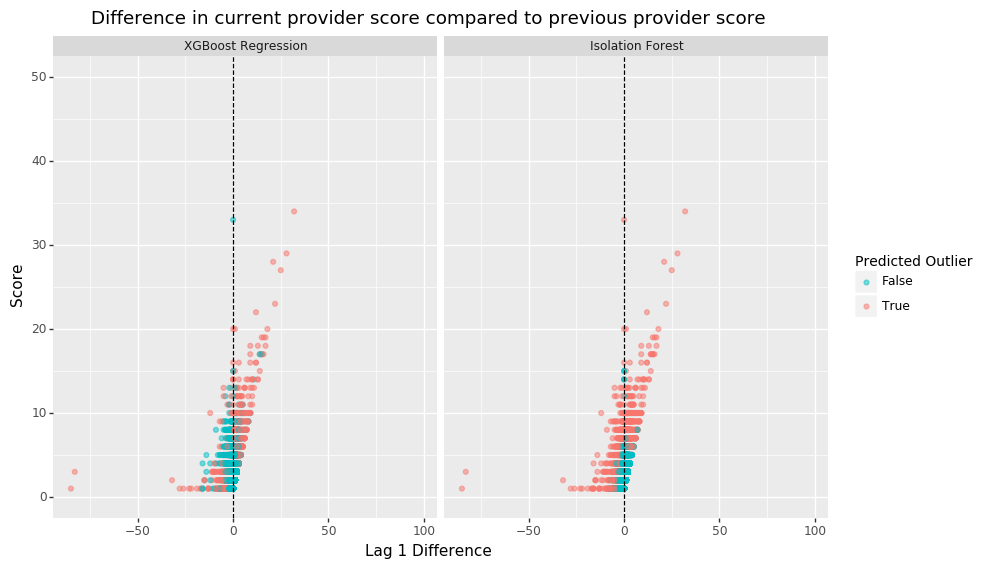

<ggplot: (8778624208353)>

In [166]:
(ggplot(comparison_df,     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.5)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + ylim([0,50])
)

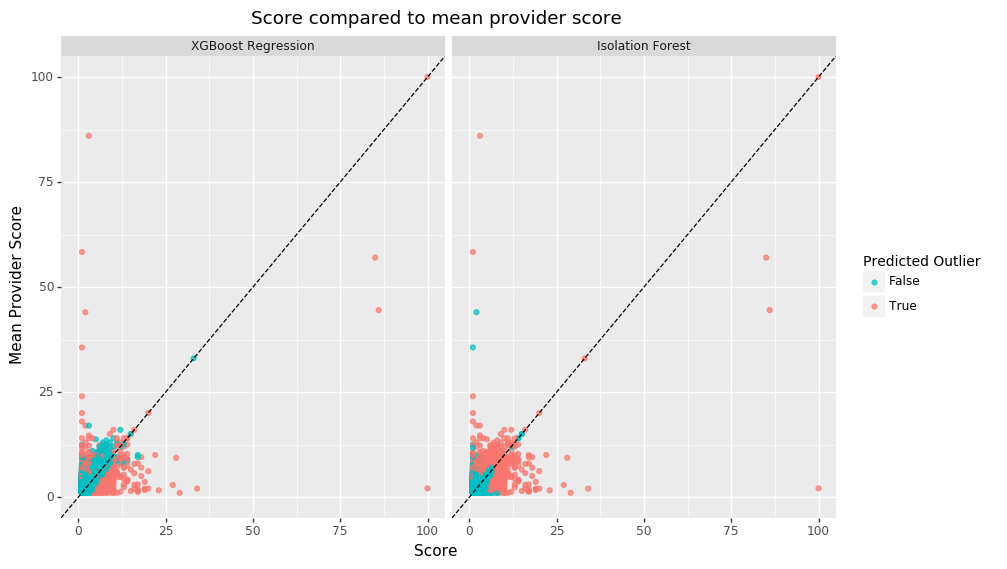

<ggplot: (8778660746729)>

In [167]:
(ggplot(comparison_df,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


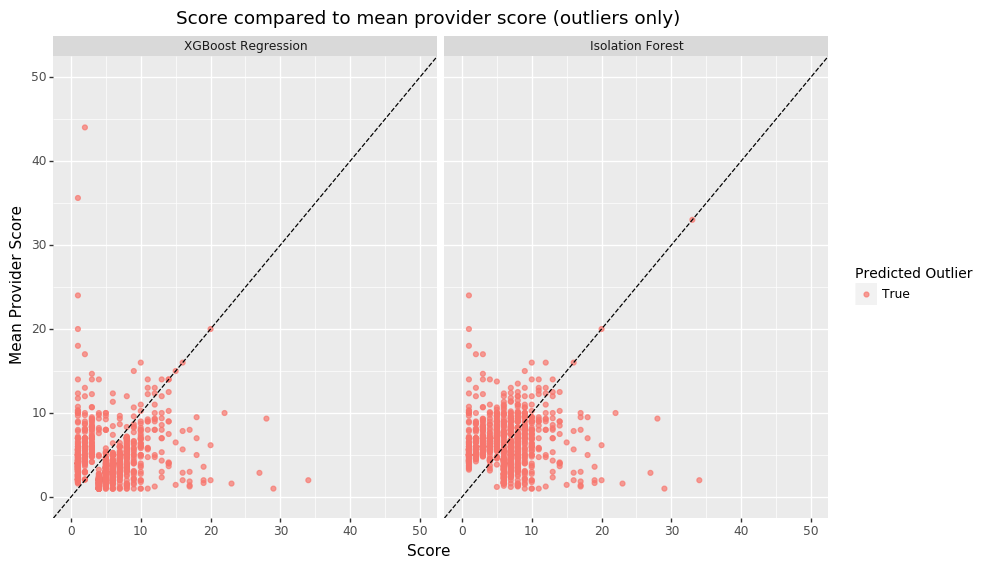

<ggplot: (8778623913577)>

In [168]:
(ggplot(comparison_df[comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (outliers only)")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,50)
 + ylim(0,50)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

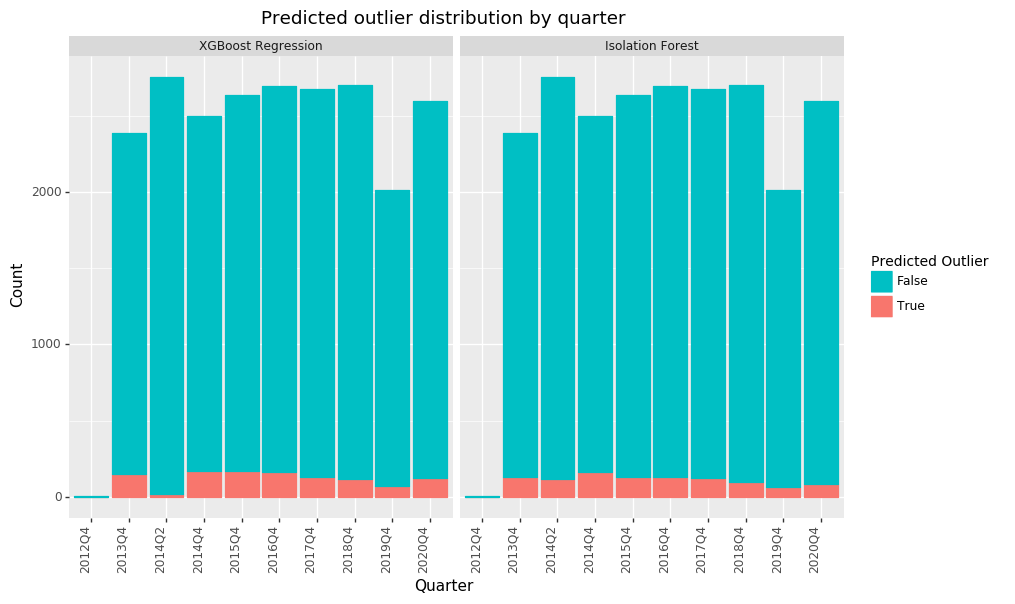

<ggplot: (8778623999969)>

In [169]:
(ggplot(comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted outlier distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

In [170]:
comparison_df.query('model == "Ensemble Model"')

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
